# Reporte de los datos de Churn de banco

In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('../data/dataset_v1.csv.zip')
df.head()

,COLE_CARACTER,COLE_DEPTO_UBICACION,COLE_GENERO,COLE_JORNADA,ESTU_ESTADOINVESTIGACION,ESTU_NACIONALIDAD,FAMI_EDUCACIONMADRE,FAMI_EDUCACIONPADRE,DESEMP_INGLES,COLE_AREA_URBANO,...,COLE_OFICIAL,SEDE_PRINCIPAL,SEXO_FEM,TIENE_AUTOMOVIL,TIENE_COMPUTADOR,TIENE_INTERNET,TIENE_LAVADORA,ESTRATOVIVIENDA,CUARTOSHOGAR,PERSONASHOGAR
0,academico,bogota,mixto,manana,publicar,colombia,tecnica_o_tecnologica_completa,tecnica_o_tecnologica_completa,0,1,...,0,1,1,0,1,1,1,0.0,2.0,3.0
1,academico,cundinamarca,mixto,completa,publicar,colombia,educacion_profesional_completa,educacion_profesional_completa,3,0,...,0,1,1,1,1,1,1,0.0,4.0,5.0
2,academico,bogota,mixto,completa,publicar,colombia,educacion_profesional_completa,educacion_profesional_completa,4,1,...,0,1,1,1,1,1,1,0.0,3.0,4.0
3,academico,cundinamarca,mixto,completa,publicar,colombia,secundaria_(bachillerato)_incompleta,secundaria_(bachillerato)_completa,4,0,...,0,1,1,1,1,1,1,0.0,2.0,3.0
4,academico,antioquia,mixto,sabatina,publicar,colombia,secundaria_(bachillerato)_incompleta,primaria_incompleta,0,1,...,0,1,1,0,0,0,1,0.0,3.0,5.0


In [46]:
interest_variable = 'DESEMP_INGLES'
X = df.drop(interest_variable, axis=1)

# print(df.groupby([interest_variable]).size())

le = LabelEncoder()
y_processed = le.fit_transform(df[interest_variable])
print("Se cargo el conjunto de datos")
print("Variable de interés {}".format(interest_variable))
print("Num. variable predictoras: {}".format(len(X.columns.to_list())))
print("Lista variable predictoras: {}".format(X.columns.to_list()))
print("Num registros: {}".format(len(X)))

cat_cols = [
    'COLE_CARACTER', 'COLE_DEPTO_UBICACION', 'COLE_GENERO', 'COLE_JORNADA',
    'ESTU_ESTADOINVESTIGACION', 'ESTU_NACIONALIDAD', 'FAMI_EDUCACIONMADRE',
    'FAMI_EDUCACIONPADRE'
    ]

num_cols = ['ESTRATOVIVIENDA', 'CUARTOSHOGAR', 'PERSONASHOGAR']

bin_cols = [
    'COLE_AREA_URBANO', 'BILINGUE', 'CALEN_A', 'COLE_OFICIAL', 
    'SEDE_PRINCIPAL', 'SEXO_FEM','TIENE_AUTOMOVIL', 'TIENE_COMPUTADOR', 
    'TIENE_INTERNET','TIENE_LAVADORA'
    ]

# 2. Definir transformaciones
preprocessor = ColumnTransformer([
    # One-Hot para categóricas
    ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    # Escalado para numéricas
    ('scale', StandardScaler(), num_cols),
    # Passthrough para binarias
    ('pass', 'passthrough', bin_cols)
])

# 3. Transformar datos
X_processed = preprocessor.fit_transform(X)

# Dividimos el conjunto de datos en train test
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, 
                                                    test_size=0.2, random_state=73)

Se cargo el conjunto de datos
Variable de interés DESEMP_INGLES
Num. variable predictoras: 21
Lista variable predictoras: ['COLE_CARACTER', 'COLE_DEPTO_UBICACION', 'COLE_GENERO', 'COLE_JORNADA', 'ESTU_ESTADOINVESTIGACION', 'ESTU_NACIONALIDAD', 'FAMI_EDUCACIONMADRE', 'FAMI_EDUCACIONPADRE', 'COLE_AREA_URBANO', 'BILINGUE', 'CALEN_A', 'COLE_OFICIAL', 'SEDE_PRINCIPAL', 'SEXO_FEM', 'TIENE_AUTOMOVIL', 'TIENE_COMPUTADOR', 'TIENE_INTERNET', 'TIENE_LAVADORA', 'ESTRATOVIVIENDA', 'CUARTOSHOGAR', 'PERSONASHOGAR']
Num registros: 446349


In [47]:
from sklearn.preprocessing import StandardScaler

scaler = scaler = StandardScaler()
data_model = X.copy()
data_model = pd.DataFrame(scaler.fit_transform(X[num_cols]),columns=num_cols)

df_dummies = pd.get_dummies(X[cat_cols], columns=cat_cols).astype(int)
columnas_nuevas = df_dummies.columns.difference(cat_cols)
df_modificado = df_dummies[columnas_nuevas]
data_model = pd.concat([data_model,df_dummies,X[bin_cols]], axis=1)

X_train, X_test, y_train, y_test = train_test_split(data_model, y_processed, 
                                                    test_size=0.2, random_state=73)

In [4]:
ohe = preprocessor.named_transformers_['ohe']
ohe_feature_names = ohe.get_feature_names_out(cat_cols)

# 2. Concatenar con nombres de columnas numéricas y binarias
column_names = list(ohe_feature_names) + num_cols + bin_cols

In [48]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import shap

# 3. Entrenar modelo XGBoost con hiperparámetros importantes
# Modelo XGBoost multiclase
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=5,
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

model.fit(X_train, y_train)

c:\Users\nicolas.arrieta\programs\conda\envs\uniandes_actd\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:48:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=5, ...)

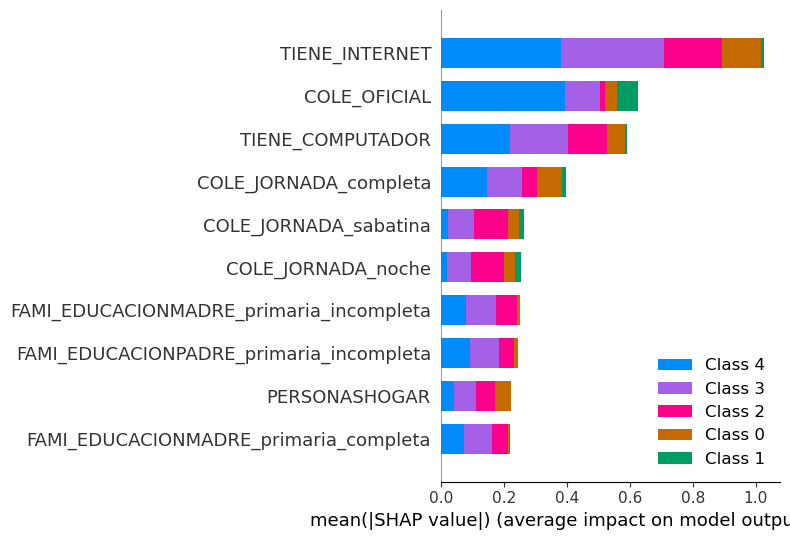

In [51]:
# 4. Inicializar SHAP con el modelo XGBoost
# Inicializar el TreeExplainer
# explainer = shap.TreeExplainer(model)

# # Obtener los valores SHAP para multiclase
# shap_values = explainer.shap_values(X_test)

import shap
# 4. Inicializar SHAP con el modelo XGBoost
explainer = shap.TreeExplainer(model)  # X_train es la base para el background

shap_values = explainer(X_test)

# 5. Gráfico resumen (summary plot)
shap.summary_plot(shap_values, X_test, max_display=10)